# Proyecto práctico

# Por: __Pablo Sáez Parra__

## Unidad 3 - Aprendizaje supervisado

El proyecto práctico consiste en abordar un problema de clasificación de documentos textuales. Tenemos a nuestra disposición un dataset de noticias de prensa en español publicada por el medio "CNN Chile".

Las noticias están divididas en 7 categorías temáticas: *'pais','deportes','tendencias','tecnologias','cultura','economia','mundo'*

El proyecto se divide en dos partes:

- Utilizar al menos 3 estrategías para entrenar modelos de clasificación capaces de clasificar las noticias según su categoría temática.

- Explorar cuáles son las características que permiten explicar las decisiones de su modelo.

## 0. Evaluación

El proyecto se realiza de forma individual. Se entrega a más tardar el **martes 15 de diciembre** en su repositorio GitHub.

**Pauta de evaluación:**

Competencia 1: Aplicar un protocolo de aprendizaje supervisado para resolver un problema clasificación estandar, utilizando un entorno de programación en Python

- < 2 : El protocolo de aprendizaje supervisado utilizado es incompleto y/o presenta errores importantes
- 2 a 3.9 : El protocolo de aprendizaje supervisado utilizado es incompleto o presenta un error importante
- 4 a 5.5 : El protocolo de aprendizaje es completo, no tiene error, pero las estrategias utilizadas son relativamente simples y el rendimiento de los modelos es perfectible.
- 5.6 a 7.0 : El protocolo de aprendizaje es completo, no tiene error y al menos una de las estrategias utilizadas a necesitado un trabajado más avanzado y/o permite obtener un mejor rendimiento.

Competencia 2: Explicar el rendimiento de un modelo de clasificación aplicando un protocolo de evaluación Precision/Recall/F-Score

- < 2 : El trabajo no presenta explicaciones del rendimiento de los modelos de clasificación
- 2 a 3.9 : El trabajo presenta algunas explicaciones pero tienen errores.
- 4 a 5.5 : El trabajo presenta explicaciones correctas del rendimiento de los modelos
- 5.6 a 7 : El trabajo presenta explicaciones correctas del rendimiento de los modelos y además presenta un método para explicar las decisiones/errores


## 1. Dataset

In [4]:
import pandas as pd
import seaborn as sb
import numpy as np
import spacy
import time
import matplotlib.pyplot as plt

df = pd.read_csv('cnnchile_7000.csv')
df

,country,media_outlet,url,title,text,date,category
0,chile,cnnchile,https://www.cnnchile.com/pais/pdta-del-colegio...,Pdta. del Colegio de Matronas explicó los ries...,La Federación de Estudiantes de la Universidad...,2018-03-29 00:00:00.000000,pais
1,chile,cnnchile,https://www.cnnchile.com/pais/defensoria-ninez...,Defensoría de la Niñez pide al Estado velar po...,La Defensoría de la Niñez emitió este domingo ...,2020-08-02 00:00:00.000000,pais
2,chile,cnnchile,https://www.cnnchile.com/pais/cuanto-les-pagar...,¿Cuánto les pagarán a los vocales de mesa?,El monto del bono es de dos tercios de Unidad ...,2016-10-20 00:00:00.000000,pais
3,chile,cnnchile,https://www.cnnchile.com/pais/sobrino-de-aleja...,Sobrino de Alejandro Navarro intenta “funar” e...,Una nueva polémica tiene esta carrera presiden...,2017-11-13 00:00:00.000000,pais
4,chile,cnnchile,https://www.cnnchile.com/pais/analisis-sobre-e...,Análisis sobre el aumento de impuestos para al...,Especialistas recomiendan no consumir más de 2...,2014-05-05 00:00:00.000000,pais
...,...,...,...,...,...,...,...
6995,chile,cnnchile,https://www.cnnchile.com/tecnologias/playstati...,PlayStation 5 vs Xbox Series X: Mira la compar...,Las compañías ya han revelado muchos detalles ...,2020-09-18 00:00:00.000000,tecnologias
6996,chile,cnnchile,https://www.cnnchile.com/tecnologias/android-l...,Android le dará “una paliza” a Windows en 2013,Se proyecta que tras un virtual empate en 2012...,2013-04-04 00:00:00.000000,tecnologias
6997,chile,cnnchile,https://www.cnnchile.com/tecnologias/regalos-t...,Regalos tecnológicos marcaron pauta en Navidad,Tablets y smartphones fueron los regalos tecno...,2012-12-26 00:00:00.000000,tecnologias
6998,chile,cnnchile,https://www.cnnchile.com/tecnologias/jugar-con...,Jugar con Fox en Starlink vale totalmente la p...,Crecí jugando clásicos de naves como Terminal ...,2018-10-30 00:00:00.000000,tecnologias


In [30]:
from pandasql import sqldf

q="""SELECT category, count(*) FROM df GROUP BY category ORDER BY count(*) DESC;"""
result=sqldf(q)
result

,category,count(*)
0,tendencias,1000
1,tecnologias,1000
2,pais,1000
3,mundo,1000
4,economia,1000
5,deportes,1000
6,cultura,1000


In [31]:
import sys

#!{sys.executable} -m spacy download es

nlp = spacy.load("es")

from sklearn import metrics

## 1.1 Preprocessing

Es necesario quitar las columnas que no dan información relevante para el análisis, como país, medio de comunicación, fecha y url.

In [32]:
data = df.drop(columns=["country", "media_outlet", "url", "date"])

data[:10]

,title,text,category
0,Pdta. del Colegio de Matronas explicó los ries...,La Federación de Estudiantes de la Universidad...,pais
1,Defensoría de la Niñez pide al Estado velar po...,La Defensoría de la Niñez emitió este domingo ...,pais
2,¿Cuánto les pagarán a los vocales de mesa?,El monto del bono es de dos tercios de Unidad ...,pais
3,Sobrino de Alejandro Navarro intenta “funar” e...,Una nueva polémica tiene esta carrera presiden...,pais
4,Análisis sobre el aumento de impuestos para al...,Especialistas recomiendan no consumir más de 2...,pais
5,Encuesta Libertad y Desarrollo: Temor a perder...,Francisco Klapp profundizó en el último sondeo...,pais
6,Presidenta decretó zona de catástrofe para reg...,La mandataria informó que recibió mensajes de ...,pais
7,Autoridades de Transporte anunciaron nuevos bu...,El Ministro de Transporte Andrés Gómez-Lobo en...,pais
8,Polémica por cantidad de casas destruidas,Confución generaron los datos entregados por l...,pais
9,Interponen nueva demanda contra CCU por prácti...,La firma ligada al grupo Luksic habría iniciad...,pais


In [33]:
data.isnull().sum()

title       1
text        0
category    0
dtype: int64

Existe 1 campo sin título, por efectos de simplicidad lo eliminaremos

In [34]:
data.dropna(inplace=True)
data.isnull().sum()

title       0
text        0
category    0
dtype: int64

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6999 entries, 0 to 6999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     6999 non-null   object
 1   text      6999 non-null   object
 2   category  6999 non-null   object
dtypes: object(3)
memory usage: 218.7+ KB


> Por efectos de simplicidad se junta el título y el texto de la noticia, añadiendo un punto entre ellos

In [108]:
data_final = data.copy()

titles = []
for title in data_final["title"]:
    titles.append(title)

index = 0
for text in data_final["text"]:
    data_final["text"][index] = titles[index] + ". " + text
    index+=1

data_final = data_final.drop(columns=["title"])

print("Solo título: ---", data["title"][0], "---")
print("Solo texto: --", data["text"][0], "--")
print("\nConcatenado título+texto: -", data_final["text"][0], "-")

data_final

Solo título: --- Pdta. del Colegio de Matronas explicó los riesgos de usar Misotrol sin supervisión médica ---
Solo texto: -- La Federación de Estudiantes de la Universidad de Chile, entregó un instructivo para enseñar cómo interrumpir un embarazo con medicamentos, lo que ha generado críticas entre médicos y expertos. “Tenemos que tener ciertas prevenciones, el Misotrol es altamente riesgoso, es cierto que la OMS dice que es el más seguro para provocar un aborto, pero bajo vigilancia médica y en condiciones estrictas en cuanto a semanas de embarazo”, informó. Además Anita Román dijo que “si el Misotrol vendido no es completo, si tiene mitad de estafa en la venta lo más probable es que la niña no aborte, pero ese poco de Misotrol le provocará secuelas al bebé”. En segundo lugar “si lo toma después de las 11 semanas y está sola se le producirá un sangramiento cuantioso y lo más probable es que tenga una anemia aguda, que necesite atención médica urgente“. La presidenta del Colegio de Mat

,text,category
0,Pdta. del Colegio de Matronas explicó los ries...,pais
1,Defensoría de la Niñez pide al Estado velar po...,pais
2,¿Cuánto les pagarán a los vocales de mesa?. El...,pais
3,Sobrino de Alejandro Navarro intenta “funar” e...,pais
4,Análisis sobre el aumento de impuestos para al...,pais
...,...,...
6995,Android le dará “una paliza” a Windows en 2013...,tecnologias
6996,Regalos tecnológicos marcaron pauta en Navidad...,tecnologias
6997,Jugar con Fox en Starlink vale totalmente la p...,tecnologias
6998,Konami lanza PES 2018 de forma gratuita para i...,tecnologias


## 1.2 Features

In [37]:
def feature_tokenizer(text):
    tokens = nlp(text)

    #Guardamos las palabras como características si se considera sustantivo, adjetivo o verbo
    tokens = [word for word in tokens if word.pos_ in ["NOUN", "ADJ", "VERB"]]
    
    #Palabras en minusculas
    tokens = [word.lemma_.lower().strip() for word in tokens]

    return tokens

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer = feature_tokenizer, min_df=0., max_df=1.0)

> Separamos la información de las etiquetas

In [38]:
X = data_final["text"]
print(X)
Y_label = data_final["category"]
print(Y_label)

0       Pdta. del Colegio de Matronas explicó los ries...
1       Defensoría de la Niñez pide al Estado velar po...
2       ¿Cuánto les pagarán a los vocales de mesa?. El...
3       Sobrino de Alejandro Navarro intenta “funar” e...
4       Análisis sobre el aumento de impuestos para al...
                              ...                        
6995    Android le dará “una paliza” a Windows en 2013...
6996    Regalos tecnológicos marcaron pauta en Navidad...
6997    Jugar con Fox en Starlink vale totalmente la p...
6998    Konami lanza PES 2018 de forma gratuita para i...
6999    Konami Digital Entertainment ha anunciado que ...
Name: text, Length: 6999, dtype: object
0              pais
1              pais
2              pais
3              pais
4              pais
           ...     
6995    tecnologias
6996    tecnologias
6997    tecnologias
6998    tecnologias
6999    tecnologias
Name: category, Length: 6999, dtype: object


> Se codifican las etiquetas para que sean mas fáciles de manejar

In [39]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

encoded_Y_labels = le.fit_transform(Y_label)
encoded_Y_labels

array([4, 4, 4, ..., 5, 5, 5])

> Guardamos los mapeos para poder saber de forma más sencilla que categoría corresponde cada etiqueta
>
> Y así poder facilitar la interpretación

In [40]:
category_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

category_mapping

{'cultura': 0,
 'deportes': 1,
 'economia': 2,
 'mundo': 3,
 'pais': 4,
 'tecnologias': 5,
 'tendencias': 6}

In [41]:
inv_category_mapping = {v: k for k, v in le_name_mapping.items()}

inv_category_mapping

{0: 'cultura',
 1: 'deportes',
 2: 'economia',
 3: 'mundo',
 4: 'pais',
 5: 'tecnologias',
 6: 'tendencias'}

> Se divide el dataset para que una parte sea usada para el entrenamiento, y otra para la evaluación

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, encoded_Y_labels, test_size=0.25)

In [43]:
X_train

3420    ¿Están usando tu Wi Fi sin permiso?. “Who is o...
492     El mensaje de los pilotos del SuperTanker para...
1709    Papa Francisco terminó su gira por Latinoaméri...
938     Ministerio Público presentó un recurso de nuli...
3691    WhatsApp suma nuevas características para faci...
                              ...                        
1860    Trump no descartó firmar nueva orden ejecutiva...
4889    Gremios agrícolas insisten en llamado a interv...
6831    Lo más destacado de la semana en la red.  En e...
5167    Las últimas canciones emitidas por Radio Magal...
6674    Microsoft emite advertencia a usuarios de Wind...
Name: text, Length: 5249, dtype: object

In [44]:
X_test

2943    Super Bowl: El mayor espectáculo deportivo de ...
6952    ¿Un iPhone 11 Pro? Qué anuncios esperar del gr...
5571    Comenzó la versión 38° de FILSA: Habrá 117 exp...
3317    Tiempo & Espacio: El rescate de lo patrimonial...
2800    Sterling y Rose fueron víctima de insultos rac...
                              ...                        
4637    El escenario económico tras el IPC de mayo. A ...
862     Viaje al Centro de la Noticia: El cartel del “...
2698    Martín Lasarte continuará al frente de Univers...
6444    Curiosity transmite canción “Reach for the Sta...
6531    Samsung presentará en marzo el nuevo Galaxy S4...
Name: text, Length: 1750, dtype: object

In [45]:
y_train

array([6, 4, 3, ..., 5, 0, 5])

In [46]:
y_test

array([1, 5, 0, ..., 1, 5, 5])

## 2.1 Regresión Logística

> La primera estrategia a utilizar será un modelo básico de regresión logística

In [47]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression()

pipe_logistic = Pipeline([('vectorizing', tfidf_vectorizer),
                 ('learning', logistic_regression_model)])

pipe_logistic.fit(X_train,y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_tokenizer at 0x000001B637223430>)),
                ('learning', LogisticRegression())])

In [50]:
predicted_logistic = pipe_logistic.predict(X_test)

print(predicted_logistic)

predicted_logistic_proba = pipe_logistic.predict_proba(X_test)

print(predicted_logistic_proba)

[6 5 4 ... 1 2 5]
[[0.13141284 0.18813697 0.03670181 ... 0.03635557 0.14021478 0.35073736]
 [0.0088367  0.00190385 0.01012345 ... 0.0017441  0.96411401 0.00627619]
 [0.14390977 0.07029909 0.11332424 ... 0.30130742 0.11283497 0.14830584]
 ...
 [0.04690205 0.6439569  0.04539977 ... 0.10179363 0.02447182 0.06529209]
 [0.03862948 0.16951203 0.2363138  ... 0.18848024 0.20524504 0.02769324]
 [0.07345796 0.05384971 0.05663509 ... 0.09223077 0.44886443 0.132705  ]]


> El modelo resulta tener una precisión bastante buena considerando su simplicidad, al lograr un 78.68% de precisión

In [51]:
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted_logistic))

Logistic Regression Accuracy: 0.7868571428571428


In [52]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

print(classification_report(y_test, predicted_logistic))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       250
           1       0.90      0.88      0.89       256
           2       0.78      0.82      0.80       248
           3       0.78      0.75      0.77       253
           4       0.71      0.74      0.73       234
           5       0.80      0.73      0.76       255
           6       0.66      0.69      0.67       254

    accuracy                           0.79      1750
   macro avg       0.79      0.79      0.79      1750
weighted avg       0.79      0.79      0.79      1750



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

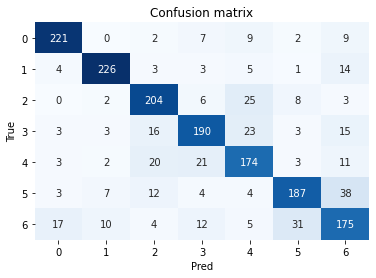

In [53]:
classes = np.unique(y_test)

cm = metrics.confusion_matrix(y_test, predicted_logistic)
fig, ax = plt.subplots()
sb.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

In [56]:
inv_category_mapping

{0: 'cultura',
 1: 'deportes',
 2: 'economia',
 3: 'mundo',
 4: 'pais',
 5: 'tecnologias',
 6: 'tendencias'}

> Este modelo es capaz de identificar excepcionalmente bien las noticias de categoría "__cultura__" y "__deportes__", consiguiendo una precisión de __88%__ y __90%__ respectivamente.
>
> Pero en categorías como "__tendencias__" y "__pais__" su rendimiento es considerablemente peor que para otras categorías, obteniendo __66%__ y __71%__ respectivamente.

## 2.2 Naïve Bayes

In [57]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

model_nb = Pipeline([('vectorizing', tfidf_vectorizer),
                 ('learning', nb)])

In [58]:
model_nb.fit(X_train, y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_tokenizer at 0x000001B637223430>)),
                ('learning', MultinomialNB())])

In [59]:
predicted_nb = model_nb.predict(X_test)

In [60]:
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted_nb))

Logistic Regression Accuracy: 0.776


In [73]:
print(classification_report(y_test, predicted_nb))

              precision    recall  f1-score   support

           0       0.70      0.93      0.80       250
           1       0.91      0.90      0.90       256
           2       0.76      0.92      0.83       248
           3       0.83      0.73      0.77       253
           4       0.75      0.73      0.74       234
           5       0.70      0.79      0.74       255
           6       0.88      0.44      0.59       254

    accuracy                           0.78      1750
   macro avg       0.79      0.78      0.77      1750
weighted avg       0.79      0.78      0.77      1750



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

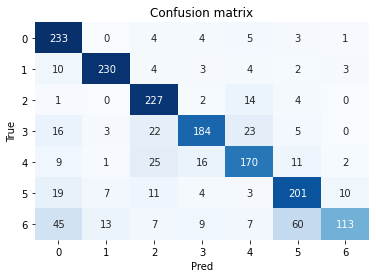

In [72]:
classes = np.unique(y_test)

cm = metrics.confusion_matrix(y_test, predicted_nb)
fig, ax = plt.subplots()
sb.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

In [132]:
inv_category_mapping

{0: 'cultura',
 1: 'deportes',
 2: 'economia',
 3: 'mundo',
 4: 'pais',
 5: 'tecnologias',
 6: 'tendencias'}

> Este modelo basado en el teorema de Bayes es capaz de identificar excepcionalmente bien las noticias de categoría "__deportes__", consiguiendo una __precisión__, __recall__ y __f1__ del 91%, 90% y 90% respectivamente.

> En general este modelo parece ser el más estable, teniendo rendimientos aceptables en la mayor parte de las categorías, aunque cabe considerar que para la categoría "tendencias" este a pesar de tener una buena precisión (__88%__), su recall es bastante deficiente (__44%__), por lo que significa que está clasificando muchas noticias que deben ser tendencias como otra categoría equivocada.

In [145]:
def top_words(class_label):
    zipped = list(zip(tfidf_vectorizer.get_feature_names(), nb.feature_log_prob_[category_mapping[class_label]]))
    return sorted(zipped, key=lambda v: v[1], reverse=True)[:10]

print("\nTop 10 palabras de Cultura: ", top_words("cultura"))
print("\nTop 10 palabras de Deporte: ", top_words("deportes"))
print("\nTop 10 palabras de Economía: ", top_words("economia"))
print("\nTop 10 palabras de Mundo: ", top_words("mundo"))
print("\nTop 10 palabras de País: ", top_words("pais"))
print("\nTop 10 palabras de Tecnologías: ", top_words("tecnologias"))
print("\nTop 10 palabras de Tendencias: ", top_words("tendencias"))


Top 10 palabras de Cultura:  [('ser', -6.6411634789620715), ('película', -6.930328715713869), ('año', -6.9535731696643595), ('canción', -7.003992786296117), ('músico', -7.010715126480778), ('artista', -7.02946959845157), ('tener', -7.097752919469575), ('nuevo', -7.176441995774134), ('decir', -7.236549515752774), ('seriar', -7.2368707674311805)]

Top 10 palabras de Deporte:  [('chileno', -6.882007682684778), ('jugador', -6.912605525989115), ('partir', -6.950869878080072), ('equipar', -7.0192797452715645), ('gol', -7.034098381472891), ('fútbol', -7.113956125076385), ('selección', -7.12199233522264), ('jugar', -7.151525364349315), ('colo', -7.167311616178111), ('ser', -7.232989807073633)]

Top 10 palabras de Economía:  [('económico', -6.9462829507132975), ('empresa', -6.988837619256565), ('economía', -7.128512966356229), ('tener', -7.129108668179045), ('mercar', -7.134291297204271), ('ser', -7.145689118670317), ('alzar', -7.152734116167527), ('año', -7.183839390557802), ('país', -7.23039

## 2.3 Arbol de decisión

In [63]:
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier()

model_tree = Pipeline([('vectorizing', tfidf_vectorizer),
                 ('learning', decision_tree)])

In [64]:
model_tree.fit(X_train, y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_tokenizer at 0x000001B637223430>)),
                ('learning', DecisionTreeClassifier())])

In [65]:
predicted_tree = model_tree.predict(X_test)

In [66]:
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted_tree))

Logistic Regression Accuracy: 0.5491428571428572


In [67]:
print(classification_report(y_test, predicted_tree))

              precision    recall  f1-score   support

           0       0.73      0.70      0.71       250
           1       0.69      0.71      0.70       256
           2       0.59      0.58      0.58       248
           3       0.47      0.46      0.47       253
           4       0.41      0.42      0.42       234
           5       0.50      0.47      0.49       255
           6       0.46      0.50      0.48       254

    accuracy                           0.55      1750
   macro avg       0.55      0.55      0.55      1750
weighted avg       0.55      0.55      0.55      1750



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

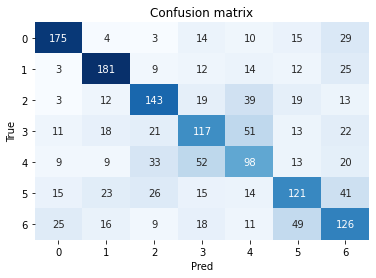

In [68]:
classes = np.unique(y_test)

cm = metrics.confusion_matrix(y_test, predicted_tree)
fig, ax = plt.subplots()
sb.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

In [74]:
inv_category_mapping

{0: 'cultura',
 1: 'deportes',
 2: 'economia',
 3: 'mundo',
 4: 'pais',
 5: 'tecnologias',
 6: 'tendencias'}

In [70]:
txt_representation = tree.export_text(decision_tree, feature_names=tfidf_vectorizer.get_feature_names(), max_depth=10)
print(txt_representation)

|--- artista <= 0.02
|   |--- jugador <= 0.04
|   |   |--- económico <= 0.05
|   |   |   |--- tecnología <= 0.03
|   |   |   |   |--- película <= 0.03
|   |   |   |   |   |--- gol <= 0.03
|   |   |   |   |   |   |--- presidente <= 0.02
|   |   |   |   |   |   |   |--- video <= 0.06
|   |   |   |   |   |   |   |   |--- usuario <= 0.04
|   |   |   |   |   |   |   |   |   |--- alzar <= 0.05
|   |   |   |   |   |   |   |   |   |   |--- canción <= 0.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 122
|   |   |   |   |   |   |   |   |   |   |--- canción >  0.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |--- alzar >  0.05
|   |   |   |   |   |   |   |   |   |   |--- violencia <= 0.03
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |   |   |   |   |--- violencia >  0.03
|   |   |   |   |   |   |   |   |   |   |   |--- class: 4
|   |   |   |  

> En general este modelo ha sido el más deficiente de entre los modelos utilizados en este proyecto, solo logrando resultados aceptables para las categorías "__cultura__" y "__deportes__", pero nada excepcionalmente bueno, solo consiguiendo f1-scores de __71%__ y __70%__ respectivamente.

## Resultados

In [112]:
print("Predicted Logistic Regression", predicted_logistic)

print("Predicted Naïve Bayes", predicted_nb)

print("Predicted Decision Tree", predicted_tree)

Predicted Logistic Regression [6 5 4 ... 1 2 5]
Predicted Naïve Bayes [6 5 0 ... 1 2 5]
Predicted Decision Tree [3 5 3 ... 1 6 5]


### Accuracy

In [147]:
from sklearn.metrics import accuracy_score

print("Logistic Regression", accuracy_score(y_test, predicted_logistic))

print("Naïve Bayes", accuracy_score(y_test, predicted_nb))

print("Decision Tree", accuracy_score(y_test, predicted_tree))

Logistic Regression 0.7868571428571428
Naïve Bayes 0.776
Decision Tree 0.5491428571428572


### Recall

In [151]:
from sklearn.metrics import recall_score

print("Logistic Regression", recall_score(y_test, predicted_logistic, average="macro"))

print("Naïve Bayes", recall_score(y_test, predicted_nb, average="macro"))

print("Decision Tree", recall_score(y_test, predicted_tree, average="macro"))

Logistic Regression 0.7866115346185162
Naïve Bayes 0.7760922454707203
Decision Tree 0.5479244229945934


### F1

In [149]:
from sklearn.metrics import f1_score

print("Logistic Regression", f1_score(y_test, predicted_logistic, average="macro"))

print("Naïve Bayes", f1_score(y_test, predicted_nb, average="macro"))

print("Decision Tree", f1_score(y_test, predicted_tree, average="macro"))

Logistic Regression 0.7867670820951338
Naïve Bayes 0.7681079755697746
Decision Tree 0.5483080088106972


In [152]:
inv_category_mapping

{0: 'cultura',
 1: 'deportes',
 2: 'economia',
 3: 'mundo',
 4: 'pais',
 5: 'tecnologias',
 6: 'tendencias'}

> En general podemos ver que tanto la "__Regresión Logística__" como "__Naïve Bayes__" funcionan relativamente bien sin mayores modificaciones ni manipulación de estos, aunque en general se puede ver que todos los modelos les cuesta clasificar en específico las categorías "__mundo__", "__pais__" y "__tendencias__", debiendose principalmente al hecho que las categorías mencionadas son considerablemente abstractas y sin características distintivas de palabras específicas que caracterizen a las categorías en específico, aunque el rendimiento de sus predicciones no son totalmente erroneas en general, y con precisión aceptable.